In [78]:
import cv2 
import numpy as np
import glob
from tqdm import tqdm
import pickle

chessboardSize = (6,8)
frameSize = (5312,2988)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

size_of_chessboard_squares_mm = 10
objp = objp * size_of_chessboard_squares_mm

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
def save_progress(objpoints, imgpoints, image_files, save_file='calibration_data.pkl'):
    with open(save_file, 'wb') as f:
        pickle.dump({'objpoints': objpoints, 'imgpoints': imgpoints, 'image_files': image_files}, f)

image_files_used = []  # Filenames of images used for calibration

def load_progress(save_file='calibration_data.pkl'):
    try:
        with open(save_file, 'rb') as f:
            data = pickle.load(f)
        return data['objpoints'], data['imgpoints'], data['image_files']
    except (FileNotFoundError, EOFError):
        return [], [], []

# Load progress from previous runs
objpoints, imgpoints, image_files_used = load_progress()

folders = ["C:/Users/gbo10/OneDrive/research/italy/torino/computer vision/31.12.2023-splitted videos"]
images = []
for folder in folders:
    images += glob.glob(folder + '/*.jpg')

new_images = []
for image in images:
    if image in image_files_used:
        continue 
    else:
        new_images.append(image)


img_counter = 0

for image in tqdm(new_images, desc="Processing images"):
    img = cv2.imread(image)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    


    # Color-segmentation to get binary mask
    lwr = np.array([0, 0, 143])
    upr = np.array([179, 61, 252])
    msk = cv2.inRange(hsv, lwr, upr)

    # Extract chess-board
    krn = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 30))
    dlt = cv2.dilate(msk, krn, iterations=5)
    res = 255 - cv2.bitwise_and(dlt, msk)

    # Displaying chess-board features
    res = np.uint8(res)
    #show res
 


    ret, corners = cv2.findChessboardCornersSB(res, chessboardSize, flags=cv2.CALIB_CB_EXHAUSTIVE+cv2.CALIB_CB_ACCURACY)    
    if ret:
        # Create a new objp array based on the number of detected corners
        chessboardSize_estimated = (int(np.sqrt(len(corners))), int(np.sqrt(len(corners))))

    # Create a new objp array based on the estimated chessboard size
    


        objpoints.append(objp)
        # Subpixel refinement on original image
        corners2 = cv2.cornerSubPix(res, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        
       

        img_counter += 1

        
        image_files_used.append(image)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, chessboardSize, corners2, ret)
        #save the image with the corners drawn
        cv2.imwrite('C:/Users/gbo10/OneDrive/research/italy/torino/computer vision/images_with_corners/corners_found'+str(img_counter)+'.jpg', img)
        cv2.namedWindow('img', cv2.WINDOW_NORMAL)
        cv2.imshow('img', img)
        cv2.waitKey(3000)
        cv2.destroyAllWindows()
        save_progress(objpoints, imgpoints, image_files_used)
   

Processing images:   0%|          | 0/337 [00:09<?, ?it/s]


error: OpenCV(4.9.0) D:\repos\opencv\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 253956096 bytes in function 'cv::OutOfMemoryError'


In [63]:
if len(objpoints[1:]) == len(imgpoints[1:]):
    ret, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints[2:], imgpoints[2:], frameSize, None, None, flags=calibration_flags)
else:
    print("Number of object points and image points are not equal.")

error: OpenCV(4.9.0) D:\repos\opencv\opencv-python\opencv\modules\calib3d\src\calibration.cpp:3416: error: (-2:Unspecified error) in function 'void __cdecl cv::collectCalibrationData(const class cv::_InputArray &,const class cv::_InputArray &,const class cv::_InputArray &,int,class cv::Mat &,class cv::Mat &,class cv::Mat *,class cv::Mat &)'
> Number of object and image points must be equal (expected: 'numberOfObjectPoints == numberOfImagePoints'), where
>     'numberOfObjectPoints' is 64
> must be equal to
>     'numberOfImagePoints' is 171


In [59]:
def load_progress(save_file='calibration_data_filtered.pkl'):
    try:
        with open(save_file, 'rb') as f:
            data = pickle.load(f)
        return data['objpoints'], data['imgpoints'], data['image_files']
    except (FileNotFoundError, EOFError):
        return [], [], []
objpoints, imgpoints, image_files_used = load_progress()
len(objpoints), len(imgpoints), len(image_files_used)


(52, 52, 52)

In [64]:
for i in range(len(objpoints)):
    if len(objpoints[i]) == len(imgpoints[i]):
        print(f"Image {i} has {len(objpoints[i])} object points and {len(imgpoints[i])} image points.")

Image 17 has 64 object points and 64 image points.
Image 28 has 64 object points and 64 image points.
Image 45 has 64 object points and 64 image points.


In [61]:
# Assuming you know the correct number of corners for your chessboard
expected_corners = 49  # Adjust this based on your chessboard configuration

filtered_objpoints = []
filtered_imgpoints = []
filtered_image_files = []

for objp, imgp, imgf in zip(objpoints, imgpoints, image_files_used):
    if len(objp) == expected_corners and len(imgp) == expected_corners:
        filtered_objpoints.append(objp)
        filtered_imgpoints.append(imgp)
        filtered_image_files.append(imgf)

# Save the filtered data
def save_filtered_data(filtered_objpoints, filtered_imgpoints, filtered_image_files):
    with open('calibration_data_filtered.pkl', 'wb') as f:
        pickle.dump({
            'objpoints': filtered_objpoints,
            'imgpoints': filtered_imgpoints,
            'image_files': filtered_image_files
        }, f)

save_filtered_data(filtered_objpoints, filtered_imgpoints, filtered_image_files)

print(f"Filtered data saved. Now, {len(filtered_objpoints)} sets of points are consistent.")



Filtered data saved. Now, 0 sets of points are consistent.


In [60]:
# Assuming frameSize is defined elsewhere

calibration_flags = (cv2.CALIB_RATIONAL_MODEL |  # Use 3 radial distortion coefficients
                     cv2.CALIB_FIX_TANGENT_DIST |  # Fix the tangential distortion; use this flag if you want to assume it's negligible
                     cv2.CALIB_FIX_K3 |  # Fix the third radial distortion coefficient; remove this if estimating it is necessary
                     cv2.CALIB_FIX_K4 |  # Fix the fourth radial distortion coefficient; remove this if estimating it is necessary
                     cv2.CALIB_FIX_K5) 
ret, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints[1:], imgpoints[1:], frameSize, None, None,flags=calibration_flags)

print("Camera Matrix:\n")
print(cameraMatrix)
print("\n")
print("Distortion Coefficients:\n")
print(dist)
print("\n")
print("Rotation Vectors:\n")
print(rvecs)
print("\n")
print("Translation Vectors:\n")
print(tvecs)
print("\n")
print("Number of images used for calibration: ", img_counter)
print("\n")
print("Calibration error: ", ret)


#save the camera matrix and distortion coefficients to a file

error: OpenCV(4.9.0) D:\repos\opencv\opencv-python\opencv\modules\calib3d\src\calibration.cpp:3416: error: (-2:Unspecified error) in function 'void __cdecl cv::collectCalibrationData(const class cv::_InputArray &,const class cv::_InputArray &,const class cv::_InputArray &,int,class cv::Mat &,class cv::Mat &,class cv::Mat *,class cv::Mat &)'
> Number of object and image points must be equal (expected: 'numberOfObjectPoints == numberOfImagePoints'), where
>     'numberOfObjectPoints' is 64
> must be equal to
>     'numberOfImagePoints' is 182


In [21]:
ret

3.556063820647521

In [ ]:
np.savez("src/measurementscalibration.npz", cameraMatrix=cameraMatrix, dist=dist, rvecs=rvecs, tvecs=tvecs,ret=ret,img_counter=img_counter)

In [ ]:
#save all to csv file
import csv

with open('src/measurementscalibration.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(["Camera Matrix"])
    writer.writerow(cameraMatrix)
    writer.writerow(["Distortion Coefficients"])
    writer.writerow(dist)
    writer.writerow(["Rotation Vectors"])
    writer.writerow(rvecs)
    writer.writerow(["Translation Vectors"])
    writer.writerow(tvecs)
    writer.writerow(["Number of images used for calibration: ", img_counter])
    #projection error
    writer.writerow(["Projection Error"])
    writer.writerow(ret)

print("Calibration done. Files saved to src folder")




total error: 0.435142010488094


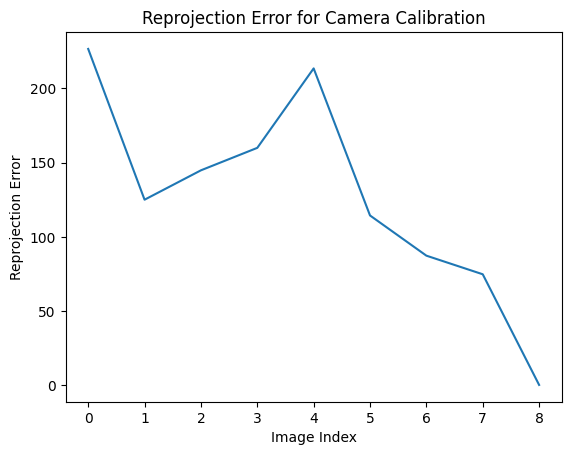

In [23]:






############## CALIBRATION #######################################################




############## UNDISTORTION #####################################################

img = cv2.imread("C:/Users/gbo10/OneDrive/research/italy/torino/computer vision/2.1.2024-splitted videos/GX010094_1_108.jpg")
h,  w = img.shape[:2]
newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))



# # Undistort
# dst = cv.undistort(img, cameraMatrix, dist, None, newCameraMatrix)

# # # crop the image
# x, y, w, h = roi
# dst = dst[y:y+h, x:x+w]
# cv.imwrite('caliResult1.png', dst)



# Undistort with Remapping
mapx, mapy = cv2.initUndistortRectifyMap(cameraMatrix, dist, None, newCameraMatrix, (w,h), 5)
dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('caliResult2.png', dst)
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
cv2.imshow('caliResult2.png', dst)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Reprojection Error
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print("total error: {}".format(mean_error/len(objpoints)))

import matplotlib.pyplot as plt

# Plotting the reprojection error
plt.plot(range(len(objpoints)), [cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2) for i in range(len(objpoints))])
plt.xlabel('Image Index')
plt.ylabel('Reprojection Error')
plt.title('Reprojection Error for Camera Calibration')
plt.show()




In [ ]:
import numpy as np
import cv2 as cv
import glob
import os 
import matplotlib.pyplot as plt 

def calibrate(showPics=True):
    # Read Image
    root = os.getcwd()
    calibrationDir = os.path.join(root,'demoImages//calibration')
    imgPathList = glob.glob(os.path.join(calibrationDir,'*.jpg'))

    # Initialize  
    nRows = 9 
    nCols = 6 
    termCriteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,30,0.001)
    worldPtsCur = np.zeros((nRows*nCols,3), np.float32)
    worldPtsCur[:,:2] = np.mgrid[0:nRows,0:nCols].T.reshape(-1,2)
    worldPtsList = []
    imgPtsList = [] 

    # Find Corners 
    for curImgPath in imgPathList:
        imgBGR = cv.imread(curImgPath)
        imgGray = cv.cvtColor(imgBGR, cv.COLOR_BGR2GRAY)
        cornersFound, cornersOrg = cv.findChessboardCornersSB(imgGray,(nRows,nCols), None)

        if cornersFound == True:
            worldPtsList.append(worldPtsCur)
            cornersRefined = cv.cornerSubPix(imgGray,cornersOrg,(11,11),(-1,-1),termCriteria)
            imgPtsList.append(cornersRefined)

            if showPics: 
                cv.drawChessboardCorners(imgBGR,(nRows,nCols),cornersRefined,cornersFound)
                cv.imshow('Chessboard', imgBGR)
                cv.waitKey(500)
    cv.destroyAllWindows()

    # Calibrate 
    repError,camMatrix,distCoeff,rvecs,tvecs = cv.calibrateCamera(worldPtsList, imgPtsList, imgGray.shape[::-1],None,None)
    print('Camera Matrix:\n',camMatrix)
    print("Reproj Error (pixels): {:.4f}".format(repError))
    
    # Save Calibration Parameters (later video)
    curFolder = os.path.dirname(os.path.abspath(__file__))
    paramPath = os.path.join(curFolder,'calibration.npz')
    np.savez(paramPath, 
        repError=repError, 
        camMatrix=camMatrix, 
        distCoeff=distCoeff, 
        rvecs=rvecs, 
        tvecs=tvecs)
    
    return camMatrix,distCoeff

def removeDistortion(camMatrix,distCoeff): 
    root = os.getcwd()
    imgPath = os.path.join(root,'demoImages//distortion2.jpg')
    img = cv.imread(imgPath)
    
    height,width = img.shape[:2]
    camMatrixNew,roi = cv.getOptimalNewCameraMatrix(camMatrix,distCoeff,(width,height),1,(width,height)) 
    imgUndist = cv.undistort(img,camMatrix,distCoeff,None,camMatrixNew)

    # Draw Line to See Distortion Change 
    cv.line(img,(1769,103),(1780,922),(255,255,255),2)
    cv.line(imgUndist,(1769,103),(1780,922),(255,255,255),2)

    plt.figure() 
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(imgUndist)
    plt.show()

def runCalibration(): 
    calibrate(showPics=True) 

def runRemoveDistortion(): 
    camMatrix,distCoeff = calibrate(showPics=False) 
    removeDistortion(camMatrix,distCoeff) 

if __name__ == '__main__': 
    # runCalibration() 
    runRemoveDistortion() 